In [427]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

In [428]:
data = pd.read_csv("weatherHistory.csv")
data

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [429]:
data["Precip Type"].unique(), data["Summary"].unique(), data["Daily Summary"].unique()

(array(['rain', 'snow', nan], dtype=object),
 array(['Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy', 'Breezy and Mostly Cloudy', 'Clear', 'Breezy and Partly Cloudy', 'Breezy and Overcast', 'Humid and Mostly Cloudy', 'Humid and Partly Cloudy', 'Windy and Foggy', 'Windy and Overcast', 'Breezy and Foggy', 'Windy and Partly Cloudy', 'Breezy', 'Dry and Partly Cloudy', 'Windy and Mostly Cloudy', 'Dangerously Windy and Partly Cloudy', 'Dry', 'Windy', 'Humid and Overcast', 'Light Rain', 'Drizzle', 'Windy and Dry', 'Dry and Mostly Cloudy', 'Breezy and Dry', 'Rain'], dtype=object),
 array(['Partly cloudy throughout the day.', 'Mostly cloudy throughout the day.', 'Foggy in the evening.', 'Foggy overnight and breezy in the morning.', 'Overcast throughout the day.', 'Partly cloudy until night.', 'Mostly cloudy until night.', 'Foggy starting overnight continuing until morning.', 'Foggy in the morning.', 'Partly cloudy until evening.', 'Partly cloudy starting in the morning.', 'Mostly cloudy s

# Preprosesamiento

In [430]:
df_encoded = data.copy()

- Conversion de variables categoricas

Codificamos la precipitacion en "Llovio" o "Nevo"

In [431]:
df_encoded = pd.get_dummies(data, columns=['Precip Type'], prefix='Precip')

In [432]:
df_encoded[["Precip_rain", "Precip_snow"]].sample(10)

,Precip_rain,Precip_snow
72807,True,False
96410,True,False
66650,False,True
28996,True,False
80002,True,False
8864,True,False
26393,True,False
42777,True,False
20483,False,True
95182,True,False


Codificamos la categoria "Summary" puntuado segun nubosidad, intensidad de viento, humedad y precipitacion

In [433]:
cloudy_map = {
    'Clear': 0,
    'Partly Cloudy': 1,
    'Mostly Cloudy': 2,
    'Overcast': 3,
    'Foggy': 4
}

wind_map = {
    'None': 0,
    'Breezy': 1,
    'Windy': 2,
    'Dangerously Windy': 3
}
humidity_map = {
    'None': 0,
    'Dry': 1,
    'Humid': 2
}

precip_map = {
    'None': 0,
    'Drizzle': 1,
    'Light Rain': 2,
    'Rain': 3
}

def extract_features(summary):
    cloud = None
    wind = 'None'
    humidity = 'None'
    precip = 'None'
  
    for cloud_type in ['Clear', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy']:
        if cloud_type in summary:
            cloud = cloud_type
            break
    
    # Buscar componente de viento
    if 'Dangerously Windy' in summary:
        wind = 'Dangerously Windy'
    elif 'Windy' in summary:
        wind = 'Windy'
    elif 'Breezy' in summary:
        wind = 'Breezy'
    
    # Buscar componente de humedad
    if 'Humid' in summary:
        humidity = 'Humid'
    elif 'Dry' in summary:
        humidity = 'Dry'
    
    # Buscar componente de precipitación
    if 'Rain' in summary and 'Light' not in summary:
        precip = 'Rain'
    elif 'Light Rain' in summary:
        precip = 'Light Rain'
    elif 'Drizzle' in summary:
        precip = 'Drizzle'
    
    return cloud, wind, humidity, precip

# Aplicar la función a cada resumen
df_encoded['cloud_value_hour'] = data['Summary'].apply(lambda x: cloudy_map.get(extract_features(x)[0], 0))
df_encoded['wind_value_hour'] = data['Summary'].apply(lambda x: wind_map.get(extract_features(x)[1], 0))
df_encoded['humidity_value_hour'] = data['Summary'].apply(lambda x: humidity_map.get(extract_features(x)[2], 0))
df_encoded['precip_value_hour'] = data['Summary'].apply(lambda x: precip_map.get(extract_features(x)[3], 0))

In [434]:
df_encoded[["Summary", "cloud_value_hour", "wind_value_hour", "humidity_value_hour", "precip_value_hour"]].sample(10)

,Summary,cloud_value_hour,wind_value_hour,humidity_value_hour,precip_value_hour
47430,Mostly Cloudy,2,0,0,0
43600,Partly Cloudy,1,0,0,0
43380,Overcast,3,0,0,0
50609,Mostly Cloudy,2,0,0,0
62225,Partly Cloudy,1,0,0,0
45155,Partly Cloudy,1,0,0,0
39228,Partly Cloudy,1,0,0,0
63706,Mostly Cloudy,2,0,0,0
53797,Partly Cloudy,1,0,0,0
49890,Partly Cloudy,1,0,0,0


In [435]:
# Primero, vamos a crear una función para determinar la estación basada en la fecha
def get_season(date_str):
    # Extraer mes y día de la fecha formateada
    date_parts = date_str.split(' ')[0].split('-')
    month = int(date_parts[1])  # El mes estará en formato MM
    day = int(date_parts[2])    # El día estará en formato DD
    
    # Definir las estaciones según los meses
    # Primavera: marzo (3) a mayo (5)
    # Verano: junio (6) a agosto (8)
    # Otoño: septiembre (9) a noviembre (11)
    # Invierno: diciembre (12), enero (1), febrero (2)
    
    if (month == 3 and day >= 20) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'Primavera'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 22):
        return 'Verano'
    elif (month == 9 and day >= 22) or (month == 10) or (month == 11) or (month == 12 and day < 21):
        return 'Otoño'
    else:  # (month == 12 and day >= 21) or (month == 1) or (month == 2) or (month == 3 and day < 20)
        return 'Invierno'

# Crear el mapeo de estaciones a valores numéricos
season_map = {
    'Primavera': 0,
    'Verano': 1,
    'Otoño': 2,
    'Invierno': 3
}

# Aplicar la función y el mapeo para obtener la columna de estación
df_encoded['Season'] = data['Formatted Date'].apply(get_season).map(season_map)

# Para la hora, extraer de la columna 'Formatted Date'
# Esto es similar a lo que ya se está haciendo en el código original con 'y'
df_encoded['Hour'] = data['Formatted Date'].str.split(' ').str[1].str.split(':').str[0].astype(int)


In [436]:
df_encoded[["Season", "Hour"]].sample(10)

,Season,Hour
58996,0,5
21252,1,12
76539,0,7
57668,0,20
9995,1,11
88332,0,15
5507,0,11
65562,1,18
30470,1,14
43256,1,8


Convertimos la columna de "Precip Type" en la etiqueta

In [437]:
# Crear una nueva columna para la etiqueta de precipitación con 3 clases
def create_precip_label(precip_type):
    if pd.isna(precip_type):  # Si es NaN, significa sin precipitación
        return 0
    elif precip_type == 'rain':
        return 1
    elif precip_type == 'snow':
        return 2
    else:
        return 0  # Por si acaso hay algún otro valor no esperado

y = pd.DataFrame()

# Aplicar la función para crear la etiqueta
y['Precip_label'] = data['Precip Type'].apply(create_precip_label)

In [438]:
y.sample(5)

,Precip_label
29351,2
18478,1
61478,1
84199,1
53052,1


Eliminamos las columnas innecesarias

In [439]:
df_encoded.sample(5)

,Formatted Date,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Precip_rain,Precip_snow,cloud_value_hour,wind_value_hour,humidity_value_hour,precip_value_hour,Season,Hour
89241,2016-12-13 12:00:00.000 +0100,Mostly Cloudy,3.716667,0.327778,0.84,14.1358,190.0,7.7280,0.0,1020.04,Mostly cloudy throughout the day.,True,False,2,0,0,0,2,12
88305,2016-04-06 12:00:00.000 +0200,Mostly Cloudy,22.755556,22.755556,0.38,15.7780,242.0,16.1000,0.0,1009.40,Partly cloudy starting in the morning.,True,False,2,0,0,0,0,12
10274,2007-12-10 02:00:00.000 +0100,Foggy,4.488889,2.727778,0.89,7.3577,54.0,2.9624,0.0,1002.29,Foggy starting in the afternoon continuing unt...,True,False,4,0,0,0,2,2
88464,2016-08-12 03:00:00.000 +0200,Partly Cloudy,10.905556,10.905556,1.00,6.3756,320.0,9.5956,0.0,1022.00,Partly cloudy throughout the day.,True,False,1,0,0,0,1,3
31019,2009-06-21 11:00:00.000 +0200,Overcast,14.911111,14.911111,0.88,12.3165,349.0,10.5133,0.0,1015.30,Overcast throughout the day.,True,False,3,0,0,0,1,11


In [440]:
df_encoded.drop(columns=["Formatted Date", "Summary", "Daily Summary", "Precip_rain", "Precip_snow"], inplace=True)

In [441]:
df_encoded.sample(10)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),cloud_value_hour,wind_value_hour,humidity_value_hour,precip_value_hour,Season,Hour
25568,10.955556,10.955556,0.93,1.3041,224.0,6.2146,0.0,1019.36,1,0,0,0,2,8
47272,-2.650000,-4.877778,0.98,5.6189,6.0,6.5044,0.0,1022.96,3,0,0,0,3,16
68148,10.966667,10.966667,0.61,6.4561,258.0,9.3702,0.0,1028.92,1,0,0,0,2,13
29536,8.955556,5.266667,0.88,29.5274,150.0,11.0768,0.0,1005.55,3,0,0,0,3,16
51956,23.111111,23.111111,0.60,2.8819,157.0,9.9820,0.0,1013.39,1,0,0,0,1,20
67568,12.755556,12.755556,0.96,7.4865,257.0,7.2772,0.0,1008.98,3,0,0,0,0,9
20868,4.005556,0.138889,0.64,17.6617,321.0,9.9820,0.0,1035.98,2,0,0,0,3,12
622,12.755556,12.755556,0.69,6.2629,235.0,15.8263,0.0,1005.49,3,0,0,0,0,22
90149,4.988889,4.988889,1.00,4.6529,148.0,1.2397,0.0,1023.58,4,0,0,0,3,8
51747,9.333333,8.711111,0.87,6.0214,141.0,14.9086,0.0,1022.22,1,0,0,0,2,3


Separamos un 10% de los datos para validacion

In [442]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.1, random_state=42)

In [443]:
X_train.head(1)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),cloud_value_hour,wind_value_hour,humidity_value_hour,precip_value_hour,Season,Hour
88408,23.911111,23.911111,0.69,9.6439,319.0,10.2557,0.0,1014.36,2,0,0,0,1,19


In [444]:
y_train.head(1)

,Precip_label
88408,1


# K-Means

Aplicamos K-Means para Aprendizaje Semi-Supervisado

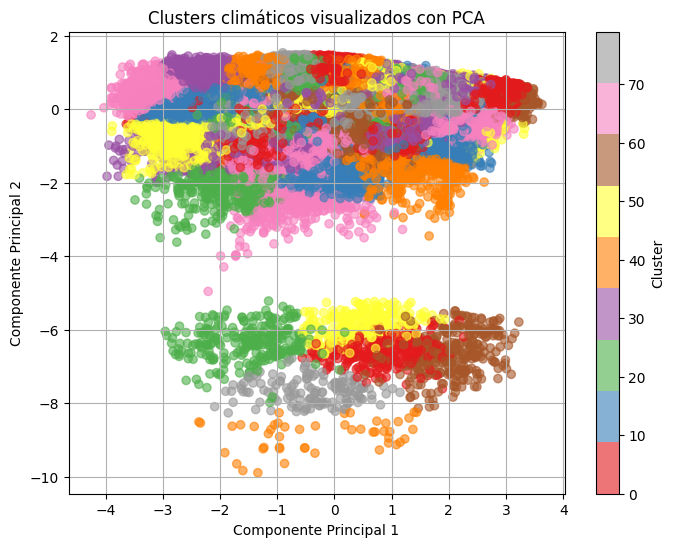

In [445]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Variables seleccionadas
features = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
X = data[features].dropna()

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=80, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# PCA para reducción a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', alpha=0.6)
plt.title("Clusters climáticos visualizados con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

In [446]:
k = 80
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

In [447]:
idxs = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train.values[idxs]

In [448]:
pd.DataFrame(X_representative_digits)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,25.094444,25.094444,0.41,10.9319,198.0,9.9820,0.0,1012.85,1.0,0.0,0.0,0.0,0.0,16.0
1,17.022222,17.022222,0.68,11.1895,97.0,9.9820,0.0,0.00,0.0,0.0,0.0,0.0,1.0,6.0
2,12.783333,12.783333,0.77,8.3881,27.0,9.9820,0.0,1018.65,1.0,0.0,0.0,0.0,0.0,9.0
3,13.244444,13.244444,1.00,6.4400,280.0,11.7530,0.0,1013.83,3.0,0.0,0.0,0.0,0.0,4.0
4,27.272222,27.261111,0.43,11.3988,147.0,10.3523,0.0,1012.44,1.0,0.0,0.0,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,5.777778,3.661111,0.81,9.7405,154.0,9.5473,0.0,1018.45,2.0,0.0,0.0,0.0,2.0,18.0
76,24.727778,24.727778,0.30,14.6027,297.0,9.9820,0.0,1014.87,1.0,0.0,0.0,0.0,1.0,15.0
77,15.972222,15.972222,0.80,8.4203,235.0,11.4471,0.0,1010.65,1.0,0.0,0.0,0.0,0.0,11.0
78,6.350000,3.827778,0.87,12.4614,198.0,11.0285,0.0,1009.38,2.0,0.0,0.0,0.0,3.0,7.0


In [449]:
print(X_representative_digits.shape)
print(X_representative_digits)

(80, 14)
[[ 2.50944444e+01  2.50944444e+01  4.10000000e-01  1.09319000e+01  1.98000000e+02  9.98200000e+00  0.00000000e+00  1.01285000e+03  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.60000000e+01]
 [ 1.70222222e+01  1.70222222e+01  6.80000000e-01  1.11895000e+01  9.70000000e+01  9.98200000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00  6.00000000e+00]
 [ 1.27833333e+01  1.27833333e+01  7.70000000e-01  8.38810000e+00  2.70000000e+01  9.98200000e+00  0.00000000e+00  1.01865000e+03  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.00000000e+00]
 [ 1.32444444e+01  1.32444444e+01  1.00000000e+00  6.44000000e+00  2.80000000e+02  1.17530000e+01  0.00000000e+00  1.01383000e+03  3.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.00000000e+00]
 [ 2.72722222e+01  2.72611111e+01  4.30000000e-01  1.13988000e+01  1.47000000e+02  

In [450]:
y_representative_digits = y_train.values[idxs]


In [451]:
from sklearn.linear_model import LogisticRegression


log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg2.fit(X_representative_digits, y_representative_digits)
log_reg2.score(X_test, y_test)

CPU times: total: 15.6 ms
Wall time: 21.5 ms


c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.9366576819407008

In [452]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg.fit(X_train[:80], y_train[:80])
log_reg.score(X_test, y_test)

CPU times: total: 15.6 ms
Wall time: 33 ms


c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.9656852581380884

In [454]:
y_train_propagated = np.empty(len(X_train))
for i in range(k):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [455]:
log_reg3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg3.fit(X_train[:1000], y_train_propagated[:1000])
log_reg3.score(X_test, y_test)

c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 594 ms
Wall time: 606 ms


0.8994401824590503

# Aprendizaje Activo

In [456]:
probas = log_reg3.predict_proba(X_train[:1000])
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
labels[sorted_ixs[:10]]

array([0.50269796, 0.5080521 , 0.51369524, 0.51701719, 0.52044524, 0.52359718, 0.5237643 , 0.52436028, 0.52679972, 0.52740433])

In [457]:
X_lowest = X_train.values[:1000][sorted_ixs[:k]]

In [465]:
y_lowest = y_train.values[:1000][sorted_ixs[:k]]
y_lowest

array([[2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [2],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1]])

In [466]:
y_train2 = y_train_propagated[:1000].copy()
y_train2[sorted_ixs[:k]] = y_lowest.flatten()

In [467]:
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(X_train[:1000], y_train2)
log_reg5.score(X_test, y_test)

c:\Users\Alberto Torrez L\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: total: 828 ms
Wall time: 861 ms


0.9206925150321377